In [1]:
import findspark
findspark.init()


In [2]:
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
from pyspark.sql import SparkSession
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, functions as sqlfunctions, types
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('nba2k-ratings').getOrCreate()

# Some NBA players that have played for the Chicago Bulls and their NBA2K19 ratings.
vertices = spark.createDataFrame([('23', 'Michael', 'Jordan', 99), 
                                  ('33', 'Scottie', 'Pippen', 97),
                                  ('1', 'Derrick', 'Rose', 94),
                                  ('53', 'Artis', 'Gilmore', 94),
                                  ('91', 'Dennis', 'Rodman', 93)],
                                  ['id', 'firstname', 'lastname', 'rating'])


# Some random associations between the players that form a connected graph.
edges = spark.createDataFrame([('23', '33'), 
                               ('33', '23'),
                              ('23', '91'),
                              ('91', '23'),
                               ('1', '33'),
                               ('33', '1'),
                               ('53', '23'),
                               ('23', '53')],
                              ['src', 'dst'])


# UDF for creating a rating data type.
def new_rating(rating, id):
    return {"id": id, "rating": rating}
player_rating_type = types.StructType([types.StructField("id", types.StringType()), types.StructField("rating", types.IntegerType())])
new_rating_udf = F.udf(new_rating, player_rating_type)

# Add as the currently known mimimum rating of each node, the rating of the node itself.
vertices = vertices.withColumn("minRating", new_rating_udf(vertices["rating"], vertices["id"]))
cached_vertices = AM.getCachedDataFrame(vertices)

# Create and print information on the respective GraphFrame
g = GraphFrame(cached_vertices, edges)
g.vertices.show()
g.edges.show()
g.degrees.show()

# UDF for preserving the minimum rating between those received by all neighbors.
def min_rating(ratings):
    min_rating = -1
    min_rating_id = -1
    for rating in ratings:
        if min_rating == -1 or rating.rating < min_rating:
            min_rating = rating.rating
            min_rating_id = rating.id
    return {"id": min_rating_id, "rating": min_rating}
min_rating_udf = F.udf(min_rating, player_rating_type)

# UDF for finding the minimum rating between the old one and the new one.
def compare_rating(old_rating, new_rating):
    return old_rating if old_rating.rating < new_rating.rating else new_rating
compare_rating_udf = F.udf(compare_rating, player_rating_type)

# Iterative graph computations
max_iterations = 5
for _ in range(max_iterations):
  aggregates = g.aggregateMessages(F.collect_set(AM.msg).alias("agg"),
              sendToDst=AM.src["minRating"])
  res = aggregates.withColumn("newMinRating", min_rating_udf("agg")).drop("agg")
  new_vertices = g.vertices.join(res, on="id", how="left_outer").withColumnRenamed("minRating", "oldMinRating").withColumn("minRating", compare_rating_udf(F.col("oldMinRating"), F.col("newMinRating"))).drop("oldMinRating").drop("newMinRating")
  cached_new_vertices = AM.getCachedDataFrame(new_vertices)
  g = GraphFrame(cached_new_vertices, g.edges)
  g.vertices.show()

+---+---------+--------+------+---------+
| id|firstname|lastname|rating|minRating|
+---+---------+--------+------+---------+
| 23|  Michael|  Jordan|    99| [23, 99]|
| 33|  Scottie|  Pippen|    97| [33, 97]|
|  1|  Derrick|    Rose|    94|  [1, 94]|
| 53|    Artis| Gilmore|    94| [53, 94]|
| 91|   Dennis|  Rodman|    93| [91, 93]|
+---+---------+--------+------+---------+

+---+---+
|src|dst|
+---+---+
| 23| 33|
| 33| 23|
| 23| 91|
| 91| 23|
|  1| 33|
| 33|  1|
| 53| 23|
| 23| 53|
+---+---+

+---+------+
| id|degree|
+---+------+
| 23|     6|
| 53|     2|
| 33|     4|
|  1|     2|
| 91|     2|
+---+------+

+---+---------+--------+------+---------+
| id|firstname|lastname|rating|minRating|
+---+---------+--------+------+---------+
| 23|  Michael|  Jordan|    99| [91, 93]|
| 53|    Artis| Gilmore|    94| [53, 94]|
| 33|  Scottie|  Pippen|    97|  [1, 94]|
|  1|  Derrick|    Rose|    94|  [1, 94]|
| 91|   Dennis|  Rodman|    93| [91, 93]|
+---+---------+--------+------+---------+

+--

In [3]:
from pyspark.sql import SparkSession    
spark = SparkSession \
        .builder \
        .appName("Python Spark Data Exploration") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [4]:
from pyspark.sql.types import *
from graphframes import *
import pandas as pd

In [5]:
fields = [
    StructField("id", StringType(), True),
    StructField("latitude", FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("population", IntegerType(), True)
]

In [6]:
v = spark.read.csv("/home/spark/lab04/task2/transport-nodes.csv", header=True, schema=StructType(fields))

In [7]:
src_dst = spark.read.csv("/home/spark/lab04/task2/transport-relationships.csv", header=True)

In [8]:
df_src_dst = src_dst.toPandas()
df_dst_src = src_dst.toPandas()
df_dst_src.columns = ["dst", "src", "relationship", "cost"]

In [9]:
e = spark.createDataFrame(pd.concat([df_src_dst, df_dst_src], sort=False))

In [10]:
g = GraphFrame(v, e)

In [11]:
(g.vertices
 .filter("population > 100000 and population < 300000")
 .sort("population")
 .show())

+----------+--------+---------+----------+
|        id|latitude|longitude|population|
+----------+--------+---------+----------+
|Colchester|51.88921|  0.90421|    104390|
|   Ipswich|52.05917|  1.15545|    133384|
+----------+--------+---------+----------+



In [12]:
from_expr = "id='Den Haag'"
to_expr = "population > 100000 and population < 300000 and id <> 'Den Haag'"
result = g.bfs(from_expr, to_expr)

In [13]:
print(result.columns)

['from', 'e0', 'v1', 'e1', 'v2', 'e2', 'to']


In [14]:
columns = [column for column in result.columns if not column.startswith("e")]
result.select(columns).show()

+--------------------+--------------------+--------------------+--------------------+
|                from|                  v1|                  v2|                  to|
+--------------------+--------------------+--------------------+--------------------+
|[Den Haag, 52.078...|[Hoek van Holland...|[Felixstowe, 51.9...|[Ipswich, 52.0591...|
+--------------------+--------------------+--------------------+--------------------+



In [15]:
result = g.shortestPaths(["Colchester", "Immingham", "Hoek van Holland"])
result.sort(["id"]).select("id", "distances").show(truncate=False)

+----------------+--------------------------------------------------------+
|id              |distances                                               |
+----------------+--------------------------------------------------------+
|Amsterdam       |[Immingham -> 1, Hoek van Holland -> 2, Colchester -> 4]|
|Colchester      |[Hoek van Holland -> 3, Immingham -> 3, Colchester -> 0]|
|Den Haag        |[Hoek van Holland -> 1, Immingham -> 2, Colchester -> 4]|
|Doncaster       |[Hoek van Holland -> 4, Immingham -> 1, Colchester -> 2]|
|Felixstowe      |[Immingham -> 4, Hoek van Holland -> 1, Colchester -> 2]|
|Gouda           |[Hoek van Holland -> 2, Immingham -> 3, Colchester -> 5]|
|Hoek van Holland|[Immingham -> 3, Hoek van Holland -> 0, Colchester -> 3]|
|Immingham       |[Hoek van Holland -> 3, Immingham -> 0, Colchester -> 3]|
|Ipswich         |[Immingham -> 4, Hoek van Holland -> 2, Colchester -> 1]|
|London          |[Hoek van Holland -> 4, Immingham -> 2, Colchester -> 1]|
|Rotterdam  

In [16]:
from graphframes.lib import AggregateMessages as AM
from pyspark.sql import functions as F

In [17]:
add_path_udf = F.udf(lambda path, id: path + [id], ArrayType(StringType()))

In [18]:
def shortest_path(g, origin, destination, column_name="cost"):
    if g.vertices.filter(g.vertices.id == destination).count() == 0:
        return (spark.createDataFrame(sc.emptyRDD(), g.vertices.schema) \
            .withColumn("path", F.array()))
    vertices = (g.vertices.withColumn("visited", F.lit(False))
        .withColumn("distance", F.when(g.vertices["id"] == origin, 0).otherwise(float("inf")))        \
        .withColumn("path", F.array()))      
    cached_vertices = AM.getCachedDataFrame(vertices)
    g2 = GraphFrame(cached_vertices, g.edges)
    while g2.vertices.filter('visited == False').first():
        current_node_id = g2.vertices.filter('visited == False').sort("distance").first().id
        msg_distance = AM.edge[column_name] + AM.src['distance']
        msg_path = add_path_udf(AM.src["path"], AM.src["id"])
        msg_for_dst = F.when(AM.src['id'] == current_node_id,F.struct(msg_distance, msg_path))
        new_distances = g2.aggregateMessages(F.min(AM.msg).alias("aggMess"),sendToDst=msg_for_dst)
        new_visited_col = F.when(     \
            g2.vertices.visited | (g2.vertices.id == current_node_id),True).otherwise(False)
        new_distance_col = F.when(new_distances["aggMess"].isNotNull() &    \
            (new_distances.aggMess["col1"] < g2.vertices.distance),new_distances.aggMess["col1"])  \
            .otherwise(g2.vertices.distance)
        new_path_col = F.when(new_distances["aggMess"].isNotNull() &  \
            (new_distances.aggMess["col1"] < g2.vertices.distance), new_distances.aggMess["col2"]   \
            .cast("array<string>")).otherwise(g2.vertices.path)
        new_vertices = (g2.vertices.join(new_distances, on="id",how="left_outer")  \
            .drop(new_distances["id"])   \
            .withColumn("visited", new_visited_col)  \
            .withColumn("newDistance", new_distance_col)  \
            .withColumn("newPath", new_path_col)  \
            .drop("aggMess", "distance", "path")  \
            .withColumnRenamed('newDistance', 'distance')  \
            .withColumnRenamed('newPath', 'path'))  
        cached_new_vertices = AM.getCachedDataFrame(new_vertices)
        g2 = GraphFrame(cached_new_vertices, g2.edges)
        if g2.vertices.filter(g2.vertices.id == destination).first().visited:
            return (g2.vertices.filter(g2.vertices.id == destination)  \
                .withColumn("newPath", add_path_udf("path", "id"))     \
                .drop("visited", "path")                               \
                .withColumnRenamed("newPath", "path"))
    return (spark.createDataFrame(sc.emptyRDD(), g.vertices.schema)    \
        .withColumn("path", F.array()))

In [19]:
result = shortest_path(g, "Amsterdam", "Colchester", "cost")
result.select("id", "distance", "path").show(truncate=False)

+----------+--------+------------------------------------------------------------------------+
|id        |distance|path                                                                    |
+----------+--------+------------------------------------------------------------------------+
|Colchester|347.0   |[Amsterdam, Den Haag, Hoek van Holland, Felixstowe, Ipswich, Colchester]|
+----------+--------+------------------------------------------------------------------------+



In [20]:
import findspark
findspark.init()

In [21]:
from pyspark.sql import SparkSession    
spark = SparkSession \
        .builder \
        .appName("Python Spark Data Exploration") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [22]:
from pyspark.sql.types import *
from graphframes import *
from pyspark.sql import functions as F
import pandas as pd

In [23]:
from graphframes.lib import AggregateMessages as AM
from pyspark.sql import functions as F

In [24]:
def create_transport_graph():
    node_fields = [
        StructField("id", StringType(), True),
        StructField("latitude", FloatType(), True),
        StructField("longitude", FloatType(), True),
        StructField("population", IntegerType(), True)
    ]
    nodes = spark.read.csv("/home/spark/lab04/task2/transport-nodes.csv", header=True,
                           schema=StructType(node_fields))

    rels = spark.read.csv("/home/spark/lab04/task2/transport-relationships.csv", header=True)
    reversed_rels = (rels.withColumn("newSrc", rels.dst)
                     .withColumn("newDst", rels.src)
                     .drop("dst", "src")
                     .withColumnRenamed("newSrc", "src")
                     .withColumnRenamed("newDst", "dst")
                     .select("src", "dst", "relationship", "cost"))
    relationships = rels.union(reversed_rels)
    return GraphFrame(nodes, relationships)

In [25]:
add_path_udf = F.udf(lambda path, id: path + [id], ArrayType(StringType()))

In [26]:
def sssp(g, origin, column_name="cost"):
    vertices = g.vertices \
        .withColumn("visited", F.lit(False)) \
        .withColumn("distance",
            F.when(g.vertices["id"] == origin, 0).otherwise(float("inf"))) \
        .withColumn("path", F.array())
    cached_vertices = AM.getCachedDataFrame(vertices)
    g2 = GraphFrame(cached_vertices, g.edges)

    while g2.vertices.filter('visited == False').first():
        current_node_id = g2.vertices.filter('visited == False').sort("distance").first().id

        msg_distance = AM.edge[column_name] + AM.src['distance']
        msg_path = add_path_udf(AM.src["path"], AM.src["id"])
        msg_for_dst = F.when(AM.src['id'] == current_node_id, F.struct(msg_distance, msg_path))
        new_distances = g2.aggregateMessages(
            F.min(AM.msg).alias("aggMess"), sendToDst=msg_for_dst)

        new_visited_col = F.when(
            g2.vertices.visited | (g2.vertices.id == current_node_id), True).otherwise(False)
        new_distance_col = F.when(new_distances["aggMess"].isNotNull() &
                                  (new_distances.aggMess["col1"] < g2.vertices.distance),
                                  new_distances.aggMess["col1"]) \
                            .otherwise(g2.vertices.distance)
        new_path_col = F.when(new_distances["aggMess"].isNotNull() &
                              (new_distances.aggMess["col1"] < g2.vertices.distance),
                              new_distances.aggMess["col2"].cast("array<string>")) \
                        .otherwise(g2.vertices.path)

        new_vertices = g2.vertices.join(new_distances, on="id", how="left_outer") \
            .drop(new_distances["id"]) \
            .withColumn("visited", new_visited_col) \
            .withColumn("newDistance", new_distance_col) \
            .withColumn("newPath", new_path_col) \
            .drop("aggMess", "distance", "path") \
            .withColumnRenamed('newDistance', 'distance') \
            .withColumnRenamed('newPath', 'path')
        cached_new_vertices = AM.getCachedDataFrame(new_vertices)
        g2 = GraphFrame(cached_new_vertices, g2.edges)

    return g2.vertices \
                .withColumn("newPath", add_path_udf("path", "id")) \
                .drop("visited", "path") \
                .withColumnRenamed("newPath", "path")

In [27]:
g = create_transport_graph() 

In [28]:
via_udf = F.udf(lambda path: path[1:-1], ArrayType(StringType()))

In [29]:
result = sssp(g, "Amsterdam", "cost")
(result
 .withColumn("via", via_udf("path"))
 .select("id", "distance", "via")
 .sort("distance")
 .show(truncate=False))

+----------------+--------+-------------------------------------------------------------+
|id              |distance|via                                                          |
+----------------+--------+-------------------------------------------------------------+
|Amsterdam       |0.0     |[]                                                           |
|Utrecht         |46.0    |[]                                                           |
|Den Haag        |59.0    |[]                                                           |
|Gouda           |81.0    |[Utrecht]                                                    |
|Rotterdam       |85.0    |[Den Haag]                                                   |
|Hoek van Holland|86.0    |[Den Haag]                                                   |
|Felixstowe      |293.0   |[Den Haag, Hoek van Holland]                                 |
|Ipswich         |315.0   |[Den Haag, Hoek van Holland, Felixstowe]                     |
|Colcheste

In [30]:
import findspark
findspark.init()

In [31]:
from pyspark.sql import SparkSession    
spark = SparkSession \
        .builder \
        .appName("Python Spark Data Exploration") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [32]:
from graphframes import *
from pyspark import SparkContext

In [33]:
v = spark.read.csv("/home/spark/lab04/task3/social-nodes.csv", header=True)
e = spark.read.csv("/home/spark/lab04/task3/social-relationships.csv", header=True)
g = GraphFrame(v, e)

In [34]:
results = g.pageRank(resetProbability=0.15, maxIter=20)
results.vertices.sort("pagerank", ascending=False).show()

+-------+-------------------+
|     id|           pagerank|
+-------+-------------------+
|   Doug| 2.2865372087512252|
|   Mark| 2.1424484186137263|
|  Alice|  1.520330830262095|
|Michael| 0.7274429252585624|
|Bridget| 0.7274429252585624|
|Charles| 0.5213852310709753|
|    Amy| 0.5097143486157744|
|  David|0.36655842368870073|
|  James| 0.1981396884803788|
+-------+-------------------+



In [35]:
results = g.pageRank(resetProbability=0.15, tol=0.01)
results.vertices.sort("pagerank", ascending=False).show()

+-------+-------------------+
|     id|           pagerank|
+-------+-------------------+
|   Doug| 2.2233188859989745|
|   Mark|  2.090451188336932|
|  Alice| 1.5056291439101062|
|Michael|  0.733738785109624|
|Bridget|  0.733738785109624|
|    Amy|  0.559446807245026|
|Charles| 0.5338811076334145|
|  David|0.40232326274180685|
|  James|0.21747203391449021|
+-------+-------------------+



In [36]:
total_degree = g.degrees
in_degree = g.inDegrees
out_degree = g.outDegrees
(total_degree.join(in_degree, "id", how="left")
  .join(out_degree, "id", how="left")
  .fillna(0)
  .sort("inDegree", ascending=False)
  .show())

+-------+------+--------+---------+
|     id|degree|inDegree|outDegree|
+-------+------+--------+---------+
|   Doug|     6|       5|        1|
|  Alice|     7|       3|        4|
|Bridget|     5|       2|        3|
|Michael|     5|       2|        3|
|   Mark|     3|       1|        2|
|Charles|     2|       1|        1|
|    Amy|     1|       1|        0|
|  David|     2|       1|        1|
|  James|     1|       0|        1|
+-------+------+--------+---------+



In [37]:
import findspark
findspark.init()

In [38]:
from graphframes import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [39]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [40]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('baza').getOrCreate()

In [41]:
nodes = spark.read.csv("/home/spark/lab04/task4/airports.csv", header=False)

In [42]:
nodes.columns

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13']

In [43]:
cleaned_nodes = (nodes.select("_c1", "_c3", "_c4", "_c6", "_c7")
                 .filter("_c3 = 'United States'")
                 .withColumnRenamed("_c1", "name")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude")
                 .drop("_c3"))

In [44]:
cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]

In [45]:
relationships = spark.read.csv("/home/spark/lab04/task4/188591317_T_ONTIME.csv", header=True)

In [46]:

cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY", "ARR_DELAY",
                                 "DISTANCE", "TAIL_NUM", "FL_NUM", "CRS_DEP_TIME",
                                 "CRS_ARR_TIME", "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay", F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay", F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime", F.col("arrivalTime").cast(IntegerType()))
                         )

In [47]:
g = GraphFrame(cleaned_nodes, cleaned_relationships)

In [48]:
airlines_reference = (spark.read.csv("/home/spark/lab04/task4/airlines.csv")
      .select("_c1", "_c3")
      .withColumnRenamed("_c1", "name")
      .withColumnRenamed("_c3", "code"))

In [49]:
airlines_reference = airlines_reference[airlines_reference["code"] != "null"]

In [50]:
df = spark.read.option("multiline", "true").json("/home/spark/lab04/task4/airlines.json")
dummyDf = spark.createDataFrame([("test", "test")], ["code", "name"])

In [51]:
for code in df.schema.fieldNames():
    tempDf = (df.withColumn("code", F.lit(code))
              .withColumn("name", df[code]))
    tdf = tempDf.select("code", "name")
    dummyDf = dummyDf.union(tdf)

In [52]:
g.vertices.count()

1333

In [53]:
g.edges.count()

616529

In [54]:
g.edges.groupBy().max("deptDelay").show()

+--------------+
|max(deptDelay)|
+--------------+
|        1632.0|
+--------------+



In [55]:
airports_degree = g.outDegrees.withColumnRenamed("id", "oId")

In [56]:
full_airports_degree = (airports_degree
                        .join(g.vertices, airports_degree.oId == g.vertices.id)
                        .sort("outDegree", ascending=False)
                        .select("id", "name", "outDegree"))

In [57]:
full_airports_degree.show(n=10, truncate=False)

+---+------------------------------------------------+---------+
|id |name                                            |outDegree|
+---+------------------------------------------------+---------+
|ATL|Hartsfield Jackson Atlanta International Airport|33837    |
|ORD|Chicago O'Hare International Airport            |28338    |
|DFW|Dallas Fort Worth International Airport         |23765    |
|CLT|Charlotte Douglas International Airport         |20251    |
|DEN|Denver International Airport                    |19836    |
|LAX|Los Angeles International Airport               |19059    |
|PHX|Phoenix Sky Harbor International Airport        |15103    |
|SFO|San Francisco International Airport             |14934    |
|LGA|La Guardia Airport                              |14709    |
|IAH|George Bush Intercontinental Houston Airport    |14407    |
+---+------------------------------------------------+---------+
only showing top 10 rows



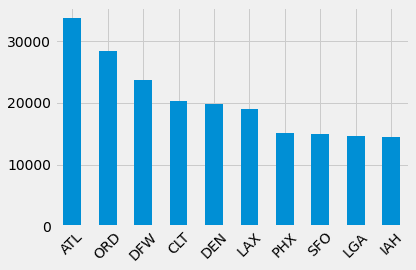

In [58]:
plt.style.use('fivethirtyeight')

ax = (full_airports_degree
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))

ax.xaxis.set_label_text("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
delayed_flights = (g.edges
                   .filter("src = 'ORD' and deptDelay > 0")
                   .groupBy("dst")
                   .agg(F.avg("deptDelay"), F.count("deptDelay"))
                   .withColumn("averageDelay", F.round(F.col("avg(deptDelay)"), 2))
                   .withColumn("numberOfDelays", F.col("count(deptDelay)")))

In [60]:
(delayed_flights
 .join(g.vertices, delayed_flights.dst == g.vertices.id)
 .sort(F.desc("averageDelay"))
 .select("dst", "name", "averageDelay", "numberOfDelays")
 .show(n=10, truncate=False))

+---+-------------------------------------------+------------+--------------+
|dst|name                                       |averageDelay|numberOfDelays|
+---+-------------------------------------------+------------+--------------+
|CKB|North Central West Virginia Airport        |145.08      |12            |
|OGG|Kahului Airport                            |119.67      |9             |
|MQT|Sawyer International Airport               |114.75      |12            |
|MOB|Mobile Regional Airport                    |102.2       |10            |
|TTN|Trenton Mercer Airport                     |101.18      |17            |
|AVL|Asheville Regional Airport                 |98.5        |28            |
|ISP|Long Island Mac Arthur Airport             |94.08       |13            |
|ANC|Ted Stevens Anchorage International Airport|83.74       |23            |
|BTV|Burlington International Airport           |83.2        |25            |
|CMX|Houghton County Memorial Airport           |79.18       |17

In [61]:
from_expr = 'id = "ORD"'
to_expr = 'id = "CKB"'
ord_to_ckb = g.bfs(from_expr, to_expr)

In [62]:
ord_to_ckb = ord_to_ckb.select(
  F.col("e0.date"),
  F.col("e0.time"),
  F.col("e0.flightNumber"),
  F.col("e0.deptDelay"))

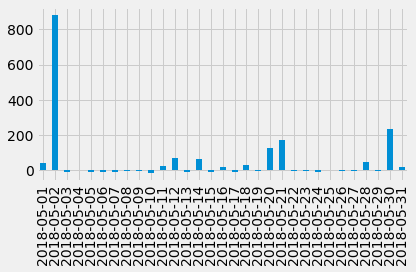

In [63]:
ax = (ord_to_ckb
      .sort("date")
      .toPandas()
      .plot(kind='bar', x='date', y='deptDelay', legend=None))

ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [64]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
          .filter("""(b.id = 'SFO') and
                  (ab.date = '2018-05-11' and bc.date = '2018-05-11') and
                  (ab.arrDelay > 30 or bc.deptDelay > 30) and
                  (ab.flightNumber = bc.flightNumber) and
                  (ab.airline = bc.airline) and
                  (ab.time < bc.time)"""))

In [65]:
def sum_dist(dist1, dist2):
    return sum([value for value in [dist1, dist2] if value is not None])

In [66]:
sum_dist_udf = F.udf(sum_dist, FloatType())


In [67]:
result = (motifs.withColumn("delta", motifs.bc.deptDelay - motifs.ab.arrDelay)
          .select("ab", "bc", "delta")
          .sort("delta", ascending=False))

In [68]:
result.select(
    F.col("ab.src").alias("a1"),
    F.col("ab.time").alias("a1DeptTime"),
    F.col("ab.arrDelay"),
    F.col("ab.dst").alias("a2"),
    F.col("bc.time").alias("a2DeptTime"),
    F.col("bc.deptDelay"),
    F.col("bc.dst").alias("a3"),
    F.col("ab.airline"),
    F.col("ab.flightNumber"),
    F.col("delta")
).show()

+---+----------+--------+---+----------+---------+---+-------+------------+-----+
| a1|a1DeptTime|arrDelay| a2|a2DeptTime|deptDelay| a3|airline|flightNumber|delta|
+---+----------+--------+---+----------+---------+---+-------+------------+-----+
|PDX|      1130|   -18.0|SFO|      1350|    178.0|BUR|     WN|        1454|196.0|
|ACV|      1755|    -9.0|SFO|      2235|     64.0|RDM|     OO|        5700| 73.0|
|BWI|       700|    -3.0|SFO|      1125|     49.0|IAD|     UA|         753| 52.0|
|ATL|       740|    40.0|SFO|      1110|     77.0|SAN|     UA|        1900| 37.0|
|BUR|      1405|    25.0|SFO|      1600|     39.0|PDX|     WN|         157| 14.0|
|DTW|       835|    34.0|SFO|      1135|     44.0|DTW|     DL|         745| 10.0|
|DEN|      1830|    25.0|SFO|      2045|     33.0|BUR|     WN|        1783|  8.0|
|PDX|      1855|   119.0|SFO|      2120|    117.0|DEN|     WN|        5789| -2.0|
|BUR|      2025|    31.0|SFO|      2230|     11.0|PHX|     WN|        1585|-20.0|
+---+----------+

In [69]:
result = g.pageRank(resetProbability=0.15, maxIter=20)
(result.vertices
 .sort("pagerank", ascending=False)
 .withColumn("pagerank", F.round(F.col("pagerank"), 2))
 .show(truncate=False, n=100))

+------------------------------------------------------------+---+------------------+-------------------+--------+
|name                                                        |id |latitude          |longitude          |pagerank|
+------------------------------------------------------------+---+------------------+-------------------+--------+
|Hartsfield Jackson Atlanta International Airport            |ATL|33.63669967651367 |-84.4281005859375  |45.17   |
|Chicago O'Hare International Airport                        |ORD|41.97859955       |-87.90480042       |40.35   |
|Dallas Fort Worth International Airport                     |DFW|32.89680099487305 |-97.03800201416016 |37.18   |
|Denver International Airport                                |DEN|39.861698150635   |-104.672996521     |28.93   |
|Charlotte Douglas International Airport                     |CLT|35.2140007019043  |-80.94309997558594 |27.65   |
|Los Angeles International Airport                           |LAX|33.94250107   

In [70]:
triangles = g.triangleCount().cache()
pagerank = g.pageRank(resetProbability=0.15, maxIter=20).cache()

(triangles.select(F.col("id").alias("tId"), "count")
 .join(pagerank.vertices, F.col("tId") == F.col("id"))
 .select("id", "name", "pagerank", "count")
 .sort("count", ascending=False)
 .withColumn("pagerank", F.round(F.col("pagerank"), 2))
 .show(truncate=False))

+---+------------------------------------------------------------+--------+-----+
|id |name                                                        |pagerank|count|
+---+------------------------------------------------------------+--------+-----+
|ATL|Hartsfield Jackson Atlanta International Airport            |45.17   |1783 |
|DEN|Denver International Airport                                |28.93   |1706 |
|ORD|Chicago O'Hare International Airport                        |40.35   |1669 |
|CLT|Charlotte Douglas International Airport                     |27.65   |1595 |
|DFW|Dallas Fort Worth International Airport                     |37.18   |1595 |
|LAS|McCarran International Airport                              |17.23   |1448 |
|MSP|Minneapolis-St Paul International/Wold-Chamberlain Airport  |22.0    |1412 |
|DTW|Detroit Metropolitan Wayne County Airport                   |20.42   |1401 |
|PHX|Phoenix Sky Harbor International Airport                    |19.09   |1333 |
|IAH|George Bush

In [71]:
airlines = (g.edges
  .groupBy("airline")
  .agg(F.count("airline").alias("flights"))
  .sort("flights", ascending=False))
full_name_airlines = (airlines_reference
  .join(airlines, airlines.airline == airlines_reference.code)
  .select("code", "name", "flights"))

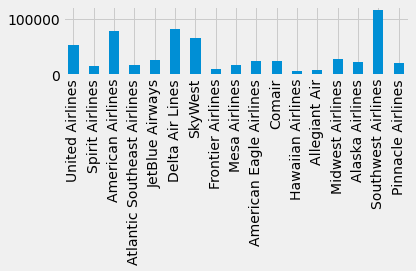

In [72]:
ax = (full_name_airlines.toPandas()
  .plot(kind='bar', x='name', y='flights', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [73]:
def find_scc_components(g, airline):
   # Create a subgraph containing only flights on the provided airline
   airline_relationships = g.edges[g.edges.airline == airline]
   airline_graph = GraphFrame(g.vertices, airline_relationships)
   # Calculate the Strongly Connected Components
   scc = airline_graph.stronglyConnectedComponents(maxIter=10)
   # Find the size of the biggest component and return that
   return (scc
     .groupBy("component")
     .agg(F.count("id").alias("size"))
     .sort("size", ascending=False)
     .take(1)[0]["size"])

In [74]:
# Calculate the largest strongly connected component for each airline
airline_scc = [(airline, find_scc_components(g, airline))
for airline in airlines.toPandas()["airline"].tolist()]
airline_scc_df = spark.createDataFrame(airline_scc, ['id', 'sccCount'])
# Join the SCC DataFrame with the airlines DataFrame so that we can show
# the number of flights an airline has alongside the number of
# airports reachable in its biggest component
airline_reach = (airline_scc_df
.join(full_name_airlines, full_name_airlines.code == airline_scc_df.id)
.select("code", "name", "flights", "sccCount")
.sort("sccCount", ascending=False))

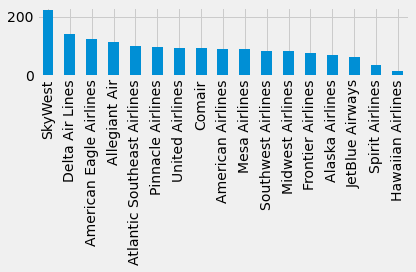

In [75]:
ax = (airline_reach.toPandas()
.plot(kind='bar', x='name', y='sccCount', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [76]:
airline_relationships = g.edges.filter("airline = 'DL'")
airline_graph = GraphFrame(g.vertices, airline_relationships)

clusters = airline_graph.labelPropagation(maxIter=10)
(clusters
 .sort("label")
 .groupby("label")
 .agg(F.collect_list("id").alias("airports"),
      F.count("id").alias("count"))
 .sort("count", ascending=False)
 .show(truncate=70, n=10))

+-------------+----------------------------------------------------------------------+-----+
|        label|                                                              airports|count|
+-------------+----------------------------------------------------------------------+-----+
|1606317768706|[IND, ORF, ATW, RIC, TRI, XNA, ECP, AVL, JAX, SYR, BHM, GSO, MEM, C...|   89|
|1219770712067|[GEG, SLC, DTW, LAS, SEA, BOS, MSN, SNA, JFK, TVC, LIH, JAC, FLL, M...|   53|
|  94489280515|                                                                 [KYK]|    1|
|  94489280517|                                                                 [RIV]|    1|
|  94489280516|                                                                 [LZZ]|    1|
|  85899345920|                                                                 [ARA]|    1|
|  94489280518|                                                                 [SDC]|    1|
| 103079215104|                                                       

In [77]:
all_flights = g.degrees.withColumnRenamed("id", "aId")

In [78]:
(clusters
.filter("label=1606317768706")
.join(all_flights, all_flights.aId == clusters.id)
 .sort("degree", ascending=False)
.select("id", "name", "degree")
.show(truncate=False))

+---+------------------------------------------------------------+------+
|id |name                                                        |degree|
+---+------------------------------------------------------------+------+
|DFW|Dallas Fort Worth International Airport                     |47514 |
|CLT|Charlotte Douglas International Airport                     |40495 |
|IAH|George Bush Intercontinental Houston Airport                |28814 |
|EWR|Newark Liberty International Airport                        |25131 |
|PHL|Philadelphia International Airport                          |20804 |
|BWI|Baltimore/Washington International Thurgood Marshall Airport|18989 |
|MDW|Chicago Midway International Airport                        |15178 |
|BNA|Nashville International Airport                             |12455 |
|DAL|Dallas Love Field                                           |12084 |
|IAD|Washington Dulles International Airport                     |11566 |
|STL|Lambert St Louis International Ai